<a href="https://colab.research.google.com/github/Riky2014/NAPDE/blob/main/cervelli_Kaggle_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install MONAI

In [ ]:
%%capture
!pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"

# Import

In [ ]:
import os
import time
import torch
import tempfile
import numpy as np
from PIL import Image
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
from nibabel import load, save, Nifti1Image

import monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.config import print_config
from monai.apps import DecathlonDataset
from monai.utils import set_determinism
from monai.networks.nets import SegResNet
from monai.handlers.utils import from_engine
from monai.visualize import plot_2d_or_3d_image
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, decollate_batch, create_test_image_3d

import gc
gc.collect()
torch.cuda.empty_cache()

from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

from monai.data import (
    DataLoader,
    decollate_batch,
    create_test_image_3d,
    create_test_image_2d,
    list_data_collate
)

2024-05-18 20:58:18.910676: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 20:58:18.910787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 20:58:19.186874: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Print configuration
This instruction is not mandatory: it just shows the details regarding the current work configuration.

In [ ]:
print_config()

MONAI version: 1.4.dev2419
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 74d904f75d57570f649488075b5dd75cc45625df
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.39.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/la

# Set the directory
Here we set the working directory.

In [ ]:
directory_path = '/kaggle/working/cervelli'
os.makedirs(directory_path, exist_ok = True)
os.environ["MONAI_DATA_DIRECTORY"] = directory_path
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

# Auxiliary functions
First of all, it is necessary to execute all the cells belonging to this section.

In [ ]:
def create_dataset(n_train, n_test):
  os.environ["MONAI_DATA_DIRECTORY"] = "/kaggle/input/patients-brains/Immagini_cervelli_giuste"
  directory = os.environ.get("MONAI_DATA_DIRECTORY")
  root_dir = tempfile.mkdtemp() if directory is None else directory

  set_determinism(seed = 0)

  images = sorted(glob(os.path.join(root_dir, "image*.nii")))
  labels = sorted(glob(os.path.join(root_dir, "label*.nii")))

  train_files = [{"image": image, "label": label} for image,
                 label in zip(images[:n_train], labels[:n_train])]
  val_files = [{"image": image, "label": label} for image,
               label in zip(images[-n_test:], labels[-n_test:])]

  return train_files, val_files

In [ ]:
def transform(train_files, val_files):
  train_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RAS"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      RandSpatialCropd(keys=["image", "label"], roi_size=[240, 240, 160], random_size=False),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
      RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
  ])

  val_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RAS"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
  ])

  train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

  val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

  return train_loader, val_loader, val_ds

In [ ]:
def inference(input, model, VAL_AMP):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

In [ ]:
def model_and_train(n_train, n_test, train_loader, val_loader, max_epochs, val_ds, filters = 16):
  print(f"Start training")
  print(f"Number of training images = {n_train}")
  print(f"Number of testing images = {n_test}")
  print()

  val_interval = 1
  VAL_AMP = True

  device = torch.device("cuda:0")
  model = SegResNet(
    blocks_down=[1, 2, 2, 4], #default: [1, 2, 2, 4]
    blocks_up=[1, 1, 1], #default: [1, 1, 1]
    init_filters=filters,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
  ).to(device)

  loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True,
                           to_onehot_y=False, sigmoid=True)
  optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

  dice_metric = DiceMetric(include_background=False, reduction="mean")        # False
  dice_metric_train = DiceMetric(include_background=False, reduction="mean")  # False

  post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

  scaler = torch.cuda.amp.GradScaler()
  torch.backends.cudnn.benchmark = True


  '''
  best_metric = -1
  best_metric_epoch = -1
  best_metrics_epochs_and_time = [[], [], []]
  '''
  epoch_loss_values = []
  metric_values = []
  metric_values_train = []

  total_start = time.time()

  for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device)
        )
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)  #inference
            loss = loss_function(outputs, labels)

        outputs = [post_trans(i) for i in decollate_batch(outputs)]  # added by the guy

        dice_metric_train(y_pred=outputs, y=labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

        '''
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
        '''

    metric_train = dice_metric_train.aggregate().item()
    metric_values_train.append(metric_train)
    dice_metric_train.reset()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Loss: {epoch_loss:.4f} \nTrain dice: {metric_train:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device)
                )
                val_outputs = inference(val_inputs, model, VAL_AMP)  #model
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()
            print(f"Test dice: {metric:.4f}")

            '''
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            '''

    print(f"Time: {(time.time() - epoch_start):.4f}")

  total_time = time.time() - total_start
  print(f"Train completed, total time: {total_time}.")
  print()
  print(f"Train metric = {metric_values_train[-1]}, Test metric = {metric_values[-1]}")
  print()
  print()

  return metric_values_train, metric_values, epoch_loss_values, model, device, VAL_AMP

In [ ]:
def plot_patient(plot_index, z_coordinate, val_ds):
  val_data_example = val_ds[plot_index]
  plt.figure("patient", (12, 6))

  #plot of the input image
  print(f"image shape: {val_data_example['image'].shape}")
  plt.subplot(1, 2, 1)
  plt.title(f"patient {plot_index}, input image")
  plt.imshow(val_data_example["image"][0,:, :,z_coordinate].detach().cpu(), cmap="gray")

  # also visualize the label corresponding to this image
  print(f"label shape: {val_data_example['label'].shape}")
  plt.subplot(1, 2, 2)
  plt.title(f"patient {plot_index}, label")
  plt.imshow(val_data_example["label"][0,:, :,z_coordinate].detach().cpu())

  plt.show()

  return

In [ ]:
def plot_metrics(epoch_loss_values, metric_values, metric_values_train, val_interval, n_train, max_epochs):
  output_dir = '/kaggle/working/output_plots'
  os.makedirs(output_dir, exist_ok=True)
  plot_path = os.path.join(output_dir,
                           f"loss and metrics, n_train = {n_train}, epochs = {max_epochs}.png")

  plt.figure("train", (18, 6))

  # Loss function
  plt.subplot(1, 3, 1)
  plt.title("Loss")
  x = [i + 1 for i in range(len(epoch_loss_values))]
  y = epoch_loss_values
  plt.xlabel("epoch")
  plt.plot(x, y, color="red")

  # Test metric
  plt.subplot(1, 3, 2)
  plt.title("Test metric")
  x = [val_interval * (i + 1) for i in range(len(metric_values))]
  y = metric_values
  plt.xlabel("epoch")
  plt.plot(x, y, color="green")

  # Train metric
  plt.subplot(1, 3, 3)
  plt.title("Train metric")
  x = [val_interval * (i + 1) for i in range(len(metric_values_train))]
  y = metric_values_train
  plt.xlabel("epoch")
  plt.plot(x, y, color="blue")

  plt.savefig(plot_path)
  plt.show()

  return

In [ ]:
def plot_test_slices(model, val_ds, VAL_AMP, patient_indices, z_axis_values):
  post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

  with torch.no_grad():
    for k in range(len(patient_indices)):
      # choose "i", index of the testing image to be plotted,
      # and "j", value of the z-axis corresponding to the
      # x-y section to be plotted
      i = patient_indices[k]
      j = z_axis_values[k]

      # select one image to evaluate and visualize the model output
      val_input = val_ds[i]["image"].unsqueeze(0).to(device)
      roi_size = (128, 128, 64)  #(240, 240, 160)
      sw_batch_size = 4
      val_output = inference(val_input, model, VAL_AMP)
      val_output = post_trans(val_output[0])

      plt.figure("current patient", (18, 6))

      #plot of the input image
      plt.subplot(1, 3, 1)
      plt.title(f"input image, patient {i}, z = {j}")
      plt.imshow(val_ds[i]["image"][0, :, :, j].detach().cpu(), cmap="gray")

      #plot of the label
      plt.subplot(1, 3, 2)
      plt.title(f"label, patient {i}, z = {j}")
      plt.imshow(val_ds[i]["label"][0, :, :, j].detach().cpu())

      #plot of the output
      plt.subplot(1, 3, 3)
      plt.title(f"output, patient {i}, z = {j}")
      plt.imshow(val_output[0, :, :, j].detach().cpu())

      plt.show()
  return

In [ ]:
def plot_test_3d(VAL_AMP, device, model, val_ds, n_train, max_epochs):
  post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
  number_val_patients = len(val_ds)

  output_dir = '/kaggle/working/test_3d_plots'
  os.makedirs(output_dir, exist_ok=True)

  with torch.no_grad():
    for i in range(number_val_patients):
      val_input = val_ds[i]["image"].unsqueeze(0).to(device)
      roi_size = (128, 128, 64)  #(240, 240, 160)
      sw_batch_size = 4
      val_output = inference(val_input, model, VAL_AMP)
      val_output = post_trans(val_output[0])

      # create figure with three subplots for display
      fig = plt.figure(figsize=(18, 6))

      # 3d plot of the input image
      ax = fig.add_subplot(131, projection = '3d')
      z, x, y = val_ds[i]["image"][0].astype(np.uint8).nonzero()
      ax.scatter(x, y, z)
      ax.set_xlim([0, 200])
      ax.set_ylim([0, 200])
      ax.set_zlim([0, 200])
      ax.set_title(f"input image, patient {i}")

      # 3d plot of the label
      ax = fig.add_subplot(132, projection = '3d')
      z, x, y = val_ds[i]["label"][0].astype(np.uint8).nonzero()
      ax.scatter(x, y, z)
      ax.set_xlim([0, 200])
      ax.set_ylim([0, 200])
      ax.set_zlim([0, 200])
      ax.set_title(f"label, patient {i}")

      # 3d plot of the output
      ax = fig.add_subplot(133, projection = '3d')
      z, x, y = val_output[0].astype(np.uint8).nonzero()
      ax.scatter(x, y, z)
      ax.set_xlim([0, 200])
      ax.set_ylim([0, 200])
      ax.set_zlim([0, 200])
      ax.set_title(f"output, patient {i}")

      # save the plots
      plot_path = os.path.join(output_dir,
                               f"test patient {i}, n_train = {n_train}, max_epochs = {max_epochs}.png")
      plt.savefig(plot_path)
      plt.show()
      plt.close(fig)

  return

# Creation of the dataset
Here, the dataset is created, and one horizontal slice of the image regarding one of the training set patients is plotted, together with the corresponding label.
Please specify:
- number of training images ("n_train": int)
- training epochs ("max_epochs": int)
- index of the patient's data to be plotted ("plot_index": int), in the set [0,...,n_train-1]
- vertical (z-axis) coordinate corresponding to the slice ("z_coordinate": int).

image shape: torch.Size([1, 250, 250, 176])
label shape: torch.Size([1, 250, 250, 176])


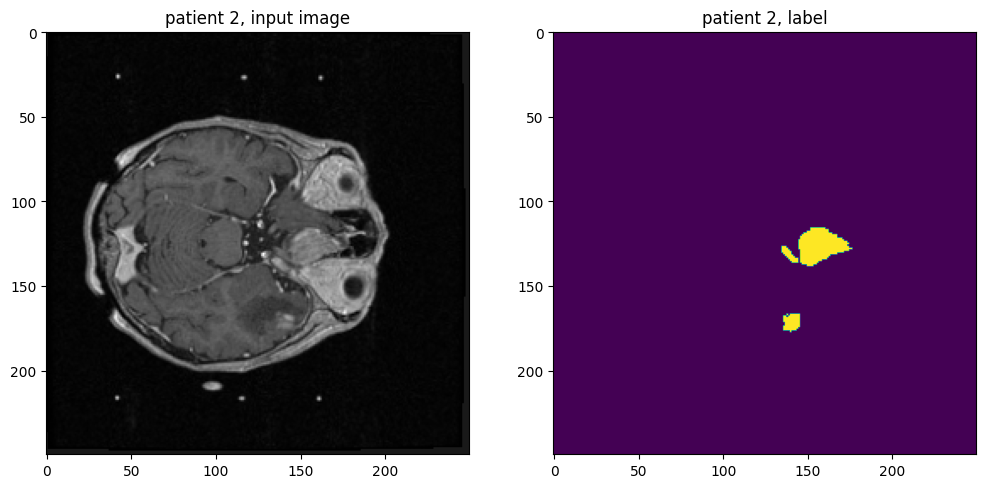

In [ ]:
n_train = 5
n_test = 10 - n_train
plot_index = 2
z_coordinate = 70

train_files, val_files = create_dataset(n_train, n_test)
train_loader, val_loader, val_ds = transform(train_files, val_files)

plot_patient(plot_index, z_coordinate, val_ds)

# Training of the U-Net
Here, the U-Net is trained.
Please specify the integer value of "max_epochs", i.e. the number of epochs of the training phase. During each epoch, the model is trained once on all the images in the train set.

In [ ]:
max_epochs = 200

metric_values_train, metric_values, epoch_loss_values, model, device, VAL_AMP = model_and_train(n_train,
                                                                                                n_test,
                                                                                                train_loader,
                                                                                                val_loader,
                                                                                                max_epochs,
                                                                                                val_ds)

Start training
Number of training images = 5
Number of testing images = 5

----------
epoch 1/200
Loss: 0.9930 
Train dice: 0.0105
Test dice: 0.0094
Time: 41.7375
----------
epoch 2/200
Loss: 0.9922 
Train dice: 0.0093
Test dice: 0.0100
Time: 33.3011
----------
epoch 3/200
Loss: 0.9916 
Train dice: 0.0092
Test dice: 0.0168
Time: 32.9397
----------
epoch 4/200
Loss: 0.9925 
Train dice: 0.0361
Test dice: 0.0109
Time: 33.4857
----------
epoch 5/200
Loss: 0.9912 
Train dice: 0.0102
Test dice: 0.0104
Time: 33.8811
----------
epoch 6/200
Loss: 0.9907 
Train dice: 0.0102
Test dice: 0.0134
Time: 33.5957
----------
epoch 7/200
Loss: 0.9905 
Train dice: 0.0139
Test dice: 0.0124
Time: 34.0661
----------
epoch 8/200
Loss: 0.9905 
Train dice: 0.0119
Test dice: 0.0125
Time: 33.3632
----------
epoch 9/200
Loss: 0.9896 
Train dice: 0.0140
Test dice: 0.0144
Time: 33.1104
----------
epoch 10/200
Loss: 0.9895 
Train dice: 0.0191
Test dice: 0.0144
Time: 33.4553
----------
epoch 11/200
Loss: 0.9891 
Train 

# Plot of the model's metrics
Here we plot the trends regarding the loss function and the Dice metric computed on train and test sets.
The plots are automatically saved in the directory: /kaggle/working/output_plots.

In [ ]:
plot_metrics(epoch_loss_values, metric_values, metric_values_train, 1, n_train, max_epochs)

NameError: name 'plot_metrics' is not defined

# Plot of the slices of some testing images
Here, we choose to show some slices (corresponding to the z-coordinate specified by the elements of the vector "z_axis_values") for the patients in the test set. For each patient, we show the  input image, the corresponding label, and the output generated by the U-Net. Please note that the vector "patients_indices" must contain only integers in the interval [0, n_test-1], so changing the number of patients in the training set (and, consequently, in the test set) may require to modify the vector. Also note that the two vectors "patients_indices" and "z_axis_values" must have the same length.

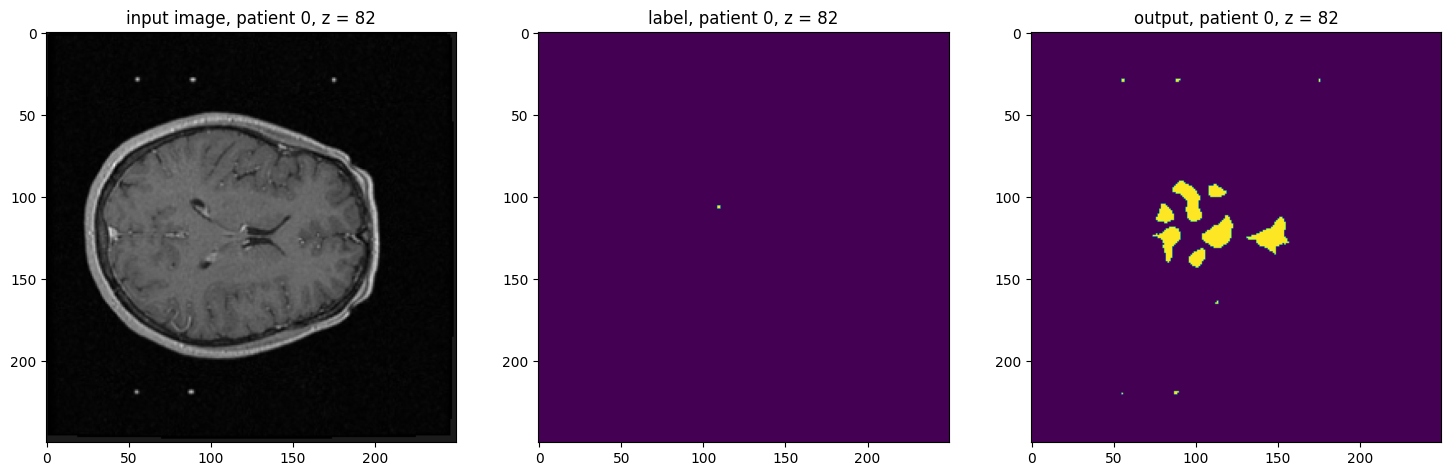

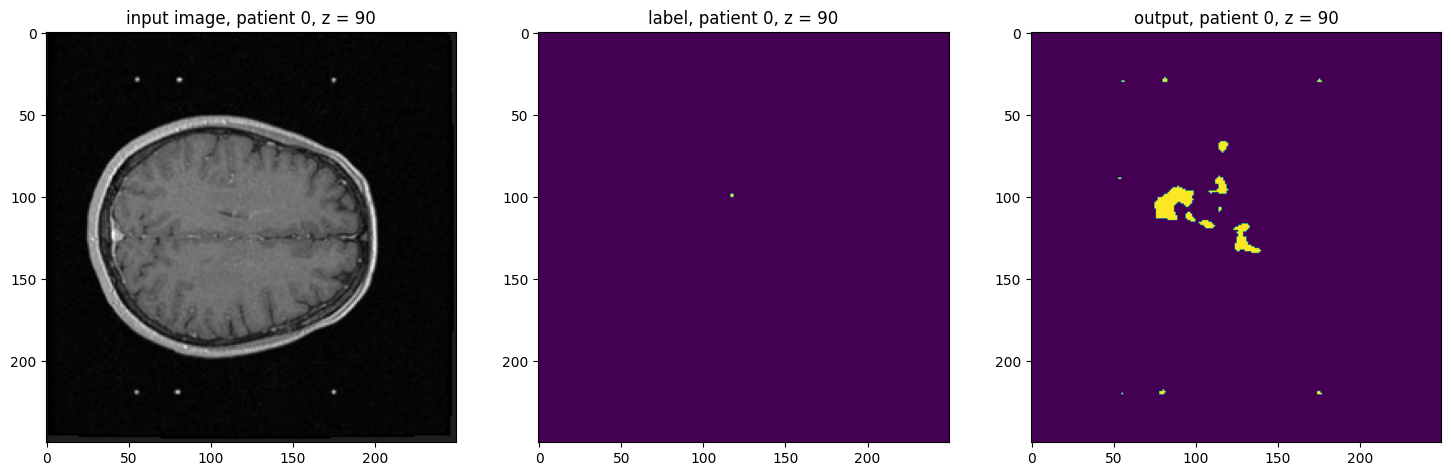

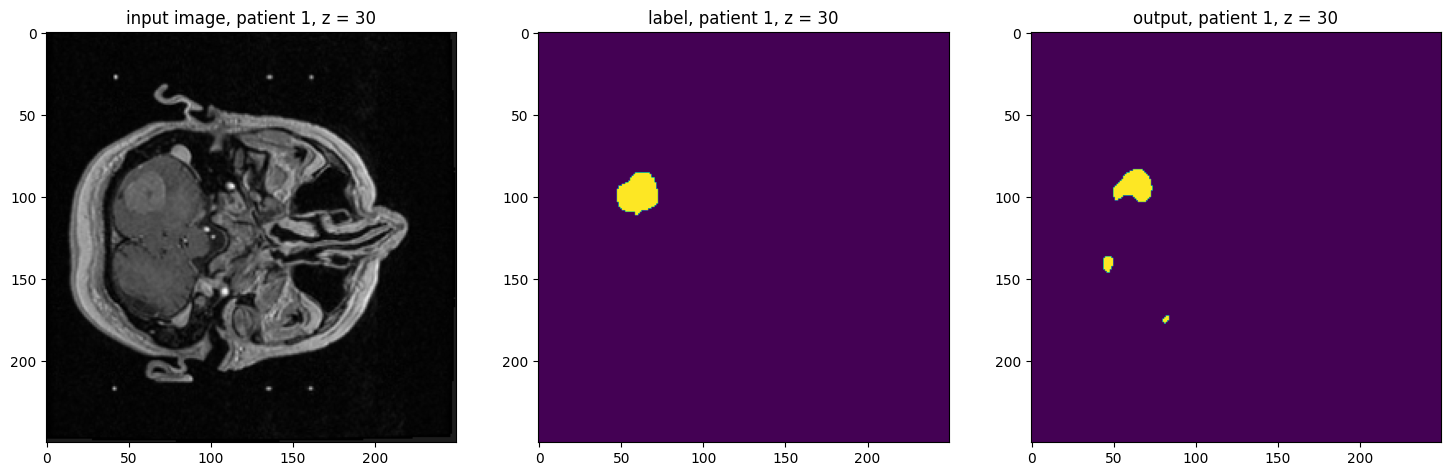

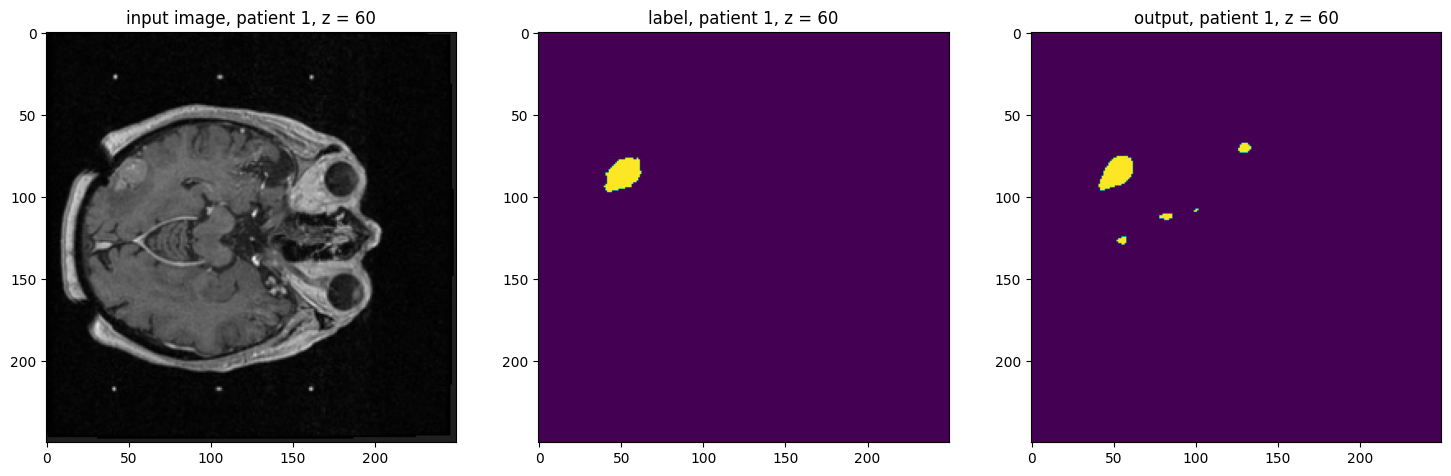

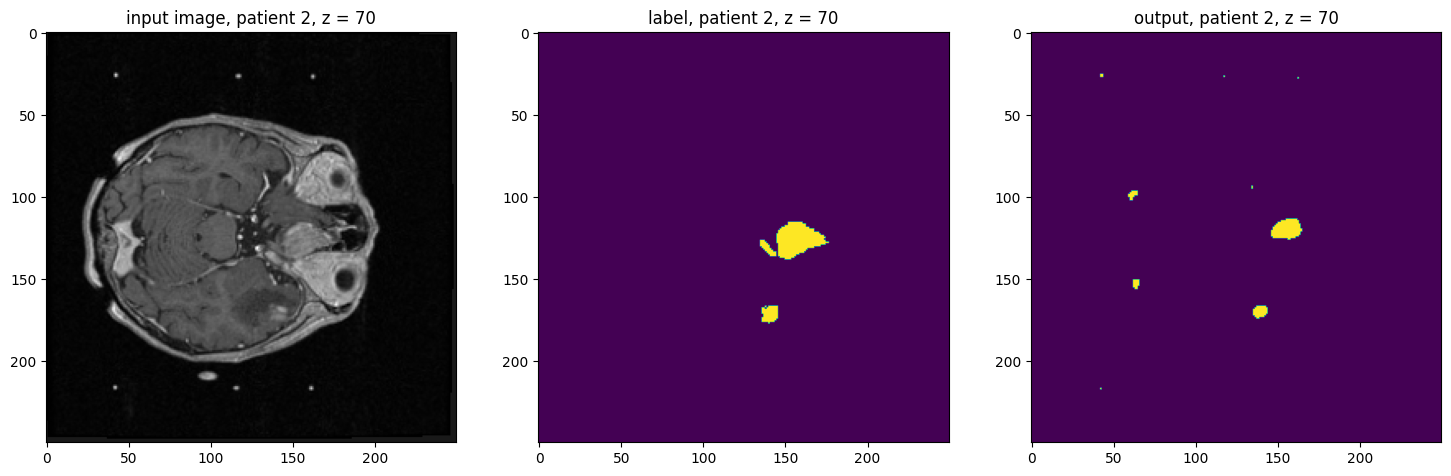

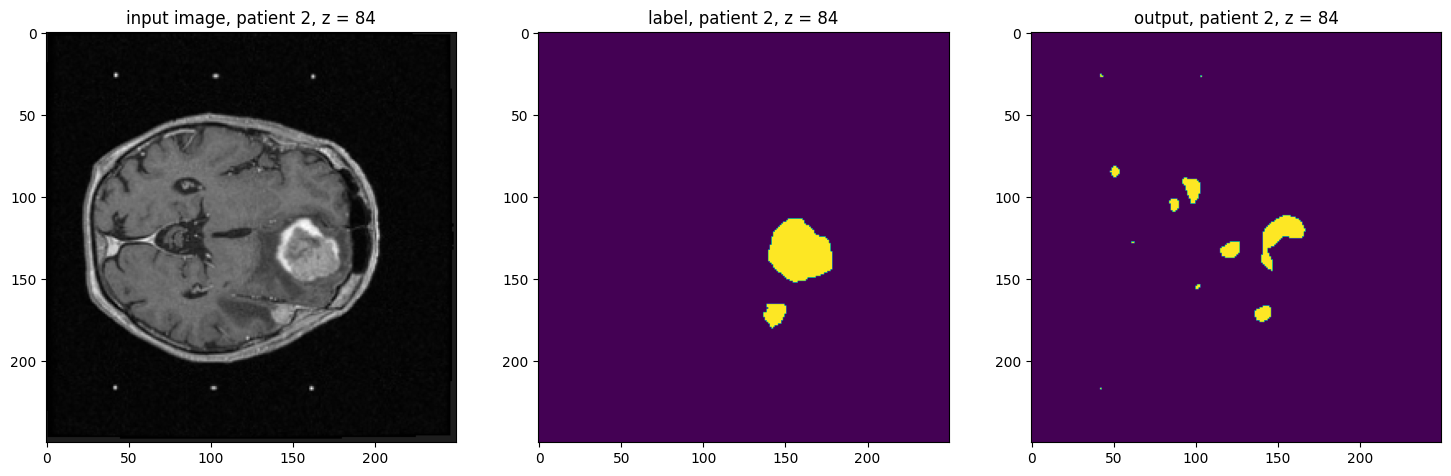

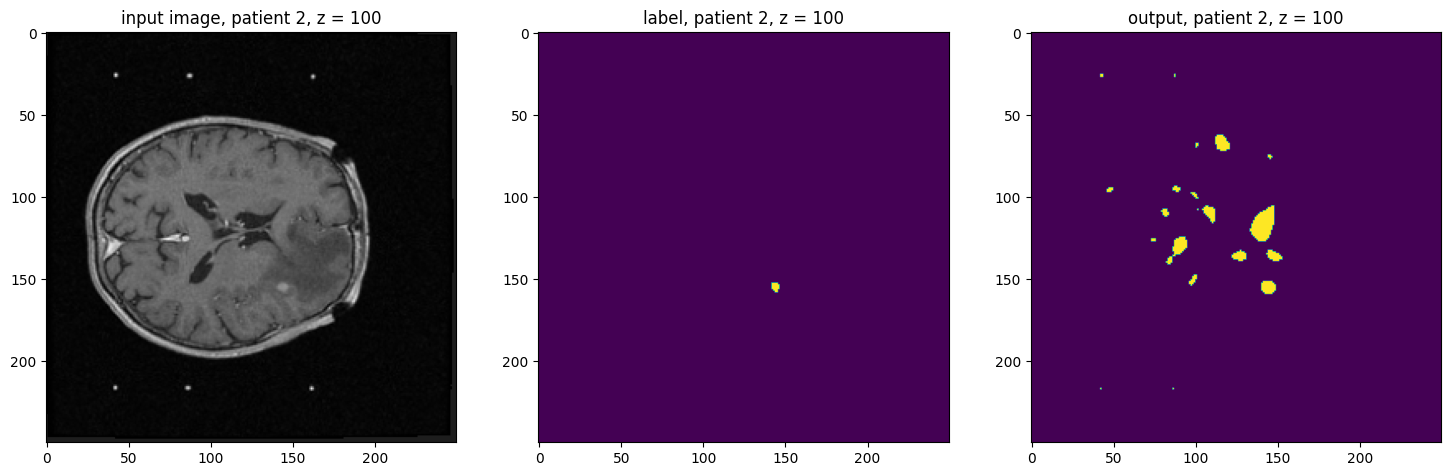

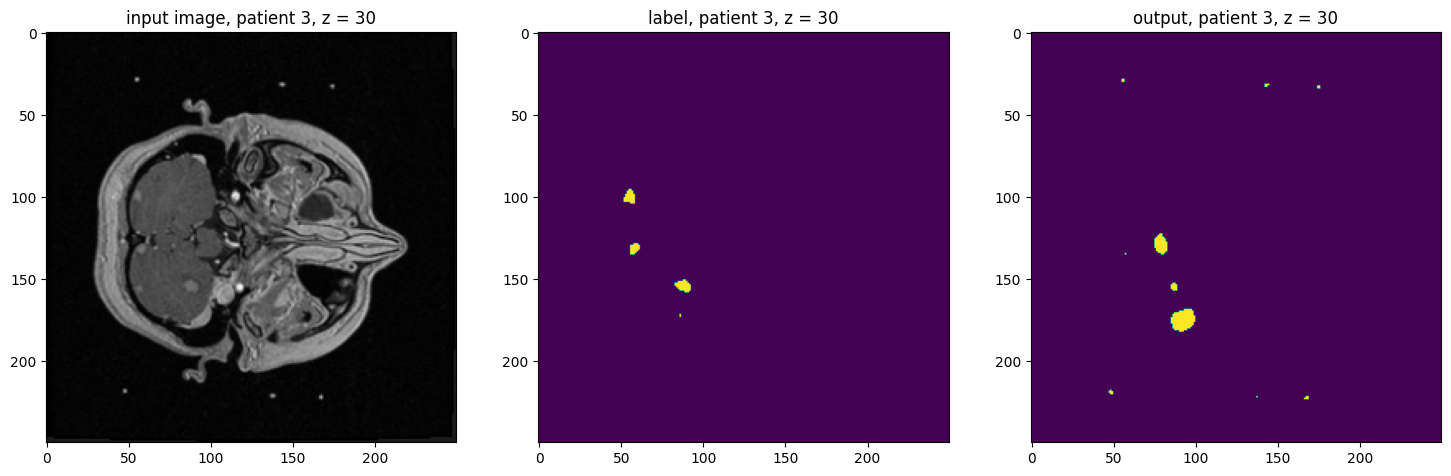

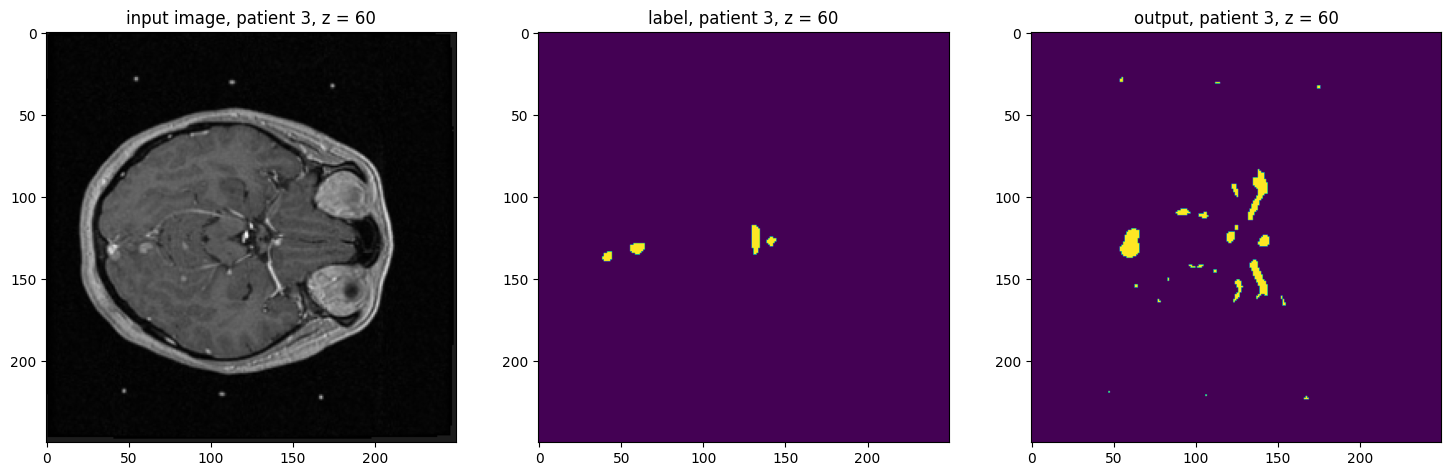

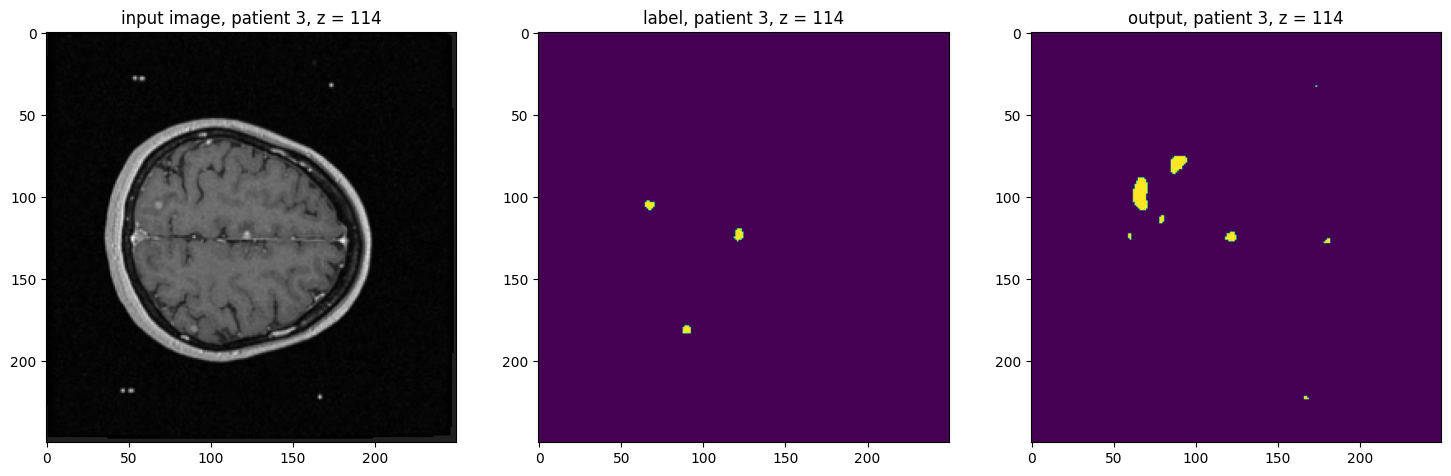

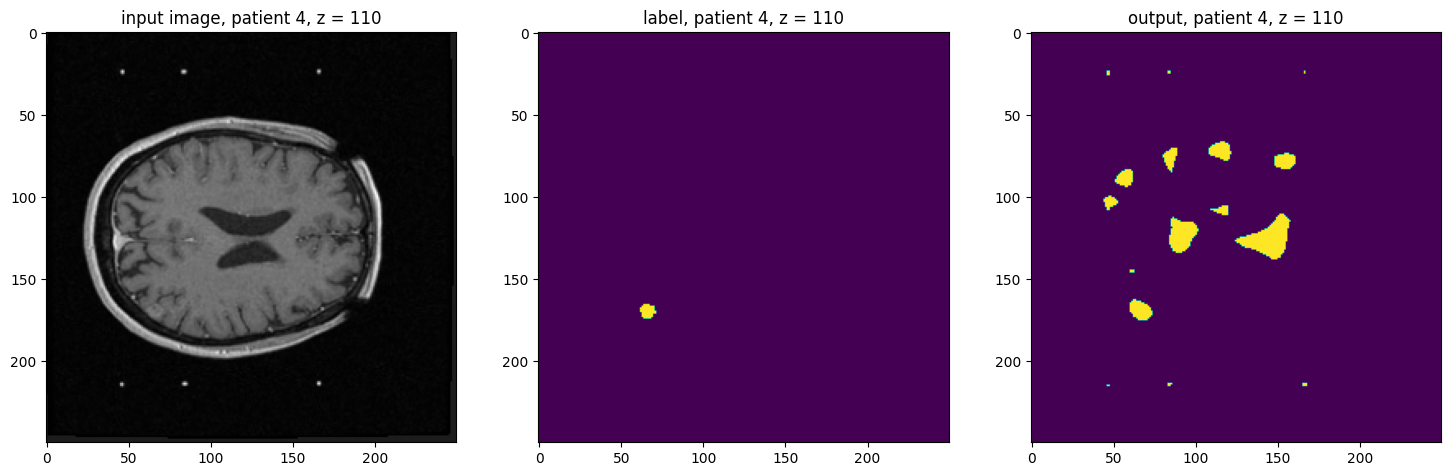

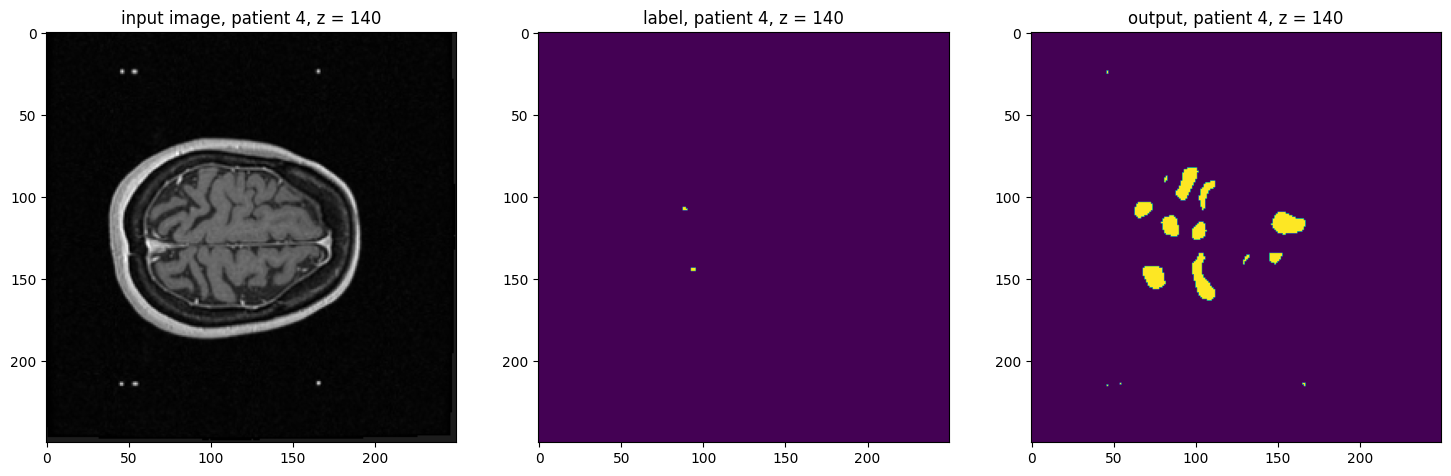

In [ ]:
patients_indices = (0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4)
z_axis_values = (82, 90, 30, 60, 70, 84, 100, 30, 60, 114, 110, 140)

plot_test_slices(model, val_ds, VAL_AMP, patients_indices, z_axis_values)

# 3D plot of all the testing images
We now show the 3D images in the test set, together with their corresponding labels, and the reconstructions generated by the U-Net. The plots are automatically saved in the directory: /kaggle/working/test_3d_plots.
Running this cell requires some minutes.

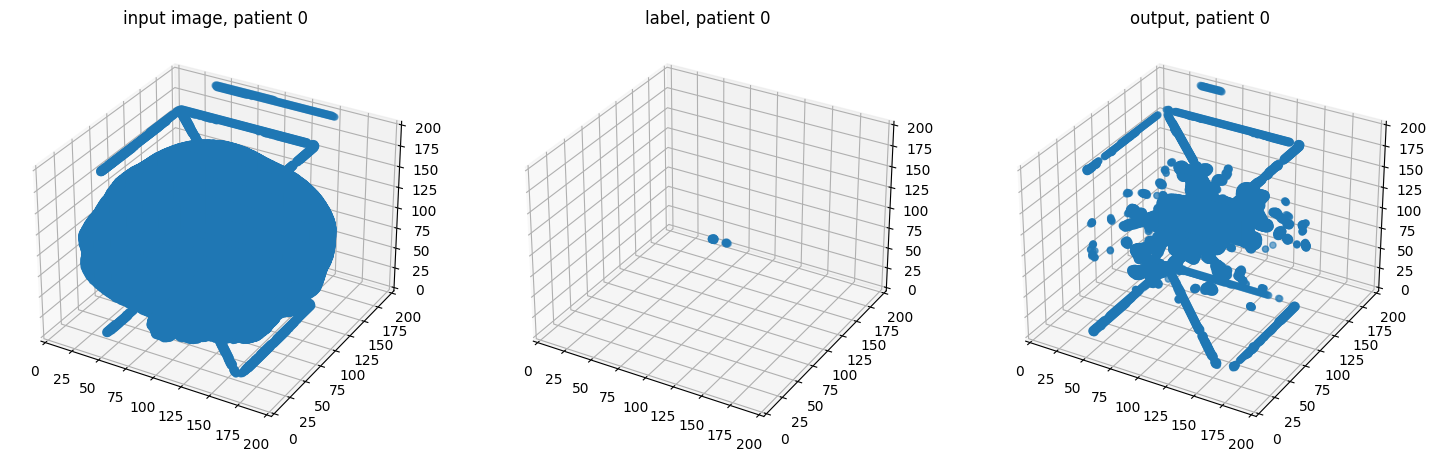

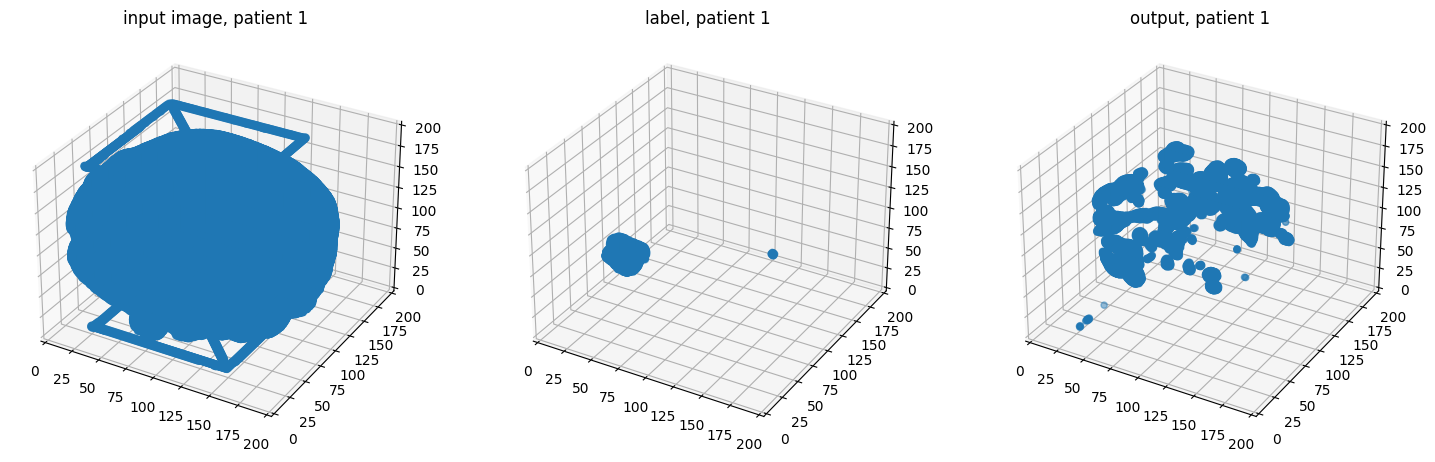

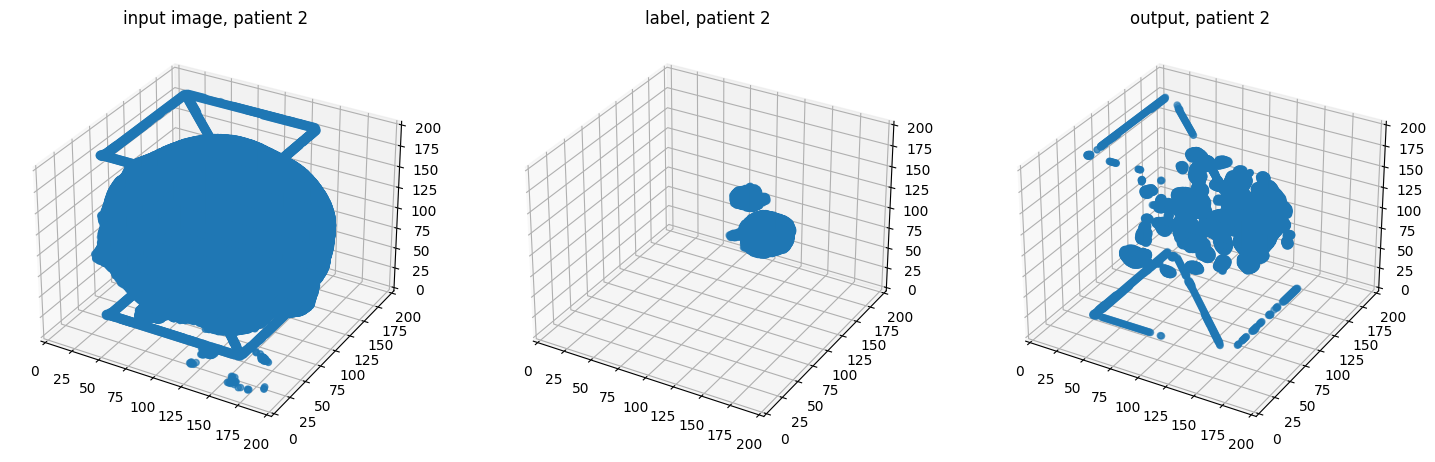

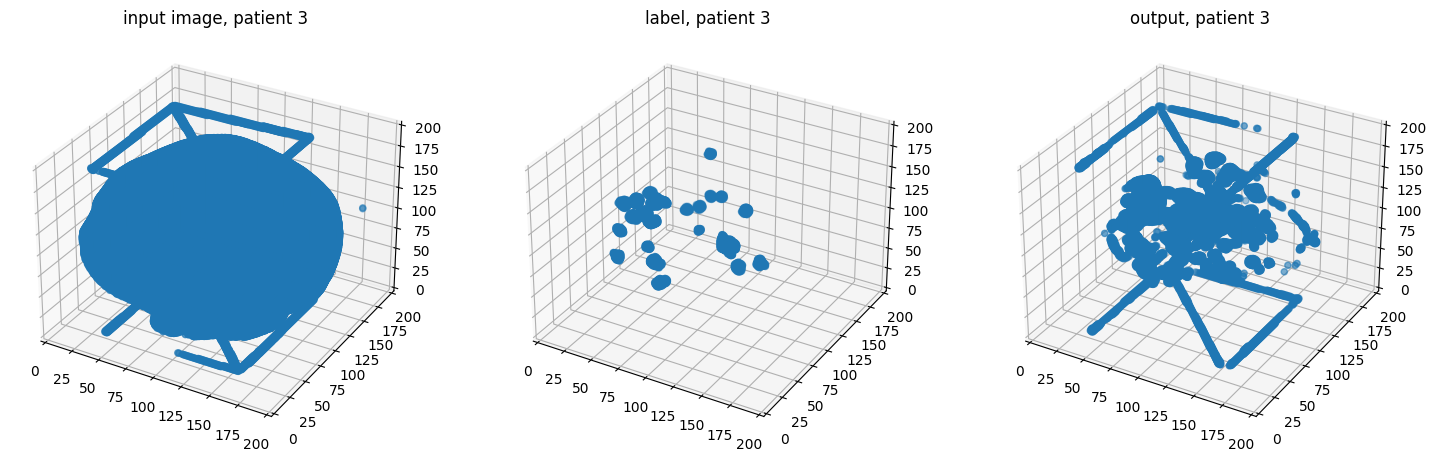

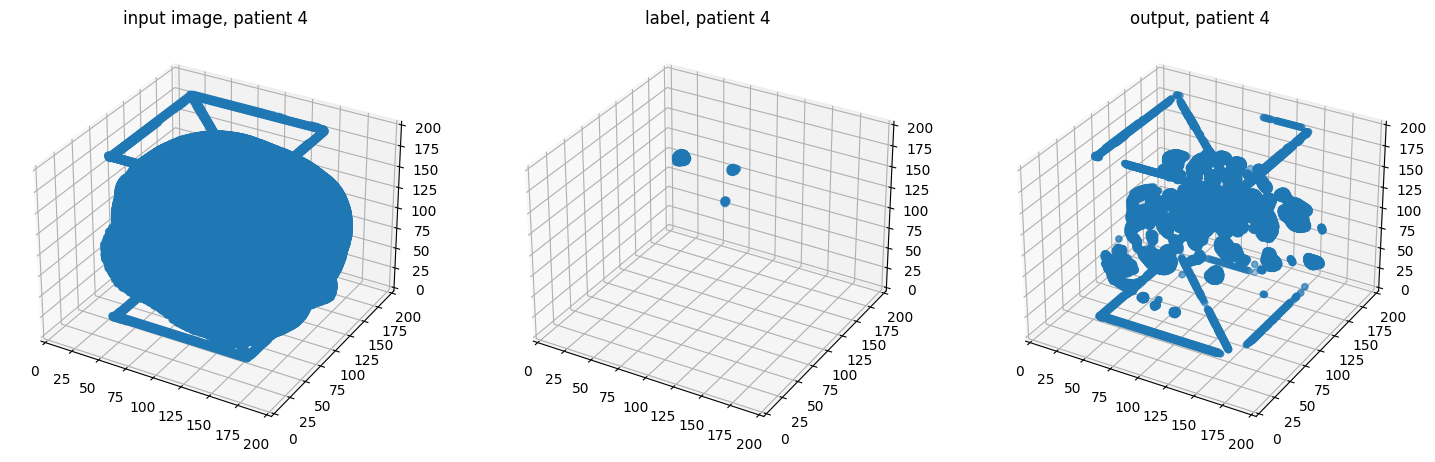

In [ ]:
plot_test_3d(VAL_AMP, device, model, val_ds, n_train, max_epochs)

# To be deleted

In [ ]:
import os
import time
import torch
import tempfile
import numpy as np
import nibabel as nib
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from nibabel import load, save, Nifti1Image

import monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism
from monai.networks.nets import SegResNet
from monai.data import DataLoader, decollate_batch, create_test_image_3d



import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
import monai
import glob
from glob import glob
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.utils import set_determinism
import nibabel as nib
from nibabel import load, save, Nifti1Image
import logging
import sys
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image
import gc
gc.collect()
torch.cuda.empty_cache()

from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

from monai.data import (
    DataLoader,
    decollate_batch,
    create_test_image_3d,
    create_test_image_2d,
    list_data_collate
)

# print_config()

In [ ]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
import monai
import glob
from glob import glob
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.utils import set_determinism
import nibabel as nib
from nibabel import load, save, Nifti1Image
import logging
import sys
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image
import gc
gc.collect()
torch.cuda.empty_cache()

from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

from monai.data import (
    DataLoader,
    decollate_batch,
    create_test_image_3d,
    create_test_image_2d,
    list_data_collate
)

print_config()

In [ ]:
#  @title 1) Image import: BraTS
os.environ["MONAI_DATA_DIRECTORY"] = "/kaggle/input/patients-brains/Immagini_cervelli_giuste"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

set_determinism(seed = 0)

images = sorted(glob(os.path.join(root_dir, "image*.nii")))
labels = sorted(glob(os.path.join(root_dir, "label*.nii")))

train_files = [{"image": image, "label": label} for image, label in zip(images[:5], labels[:5])]
val_files = [{"image": image, "label": label} for image, label in zip(images[-5:], labels[-5:])]

In [ ]:
# @title Dataset creation

train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image","label"]),
        EnsureTyped(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[240, 240, 160], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)


val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image","label"]),
        EnsureTyped(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

check_data = monai.utils.misc.first(train_loader)
print(check_data["image"].shape, check_data["label"].shape)

In [ ]:
# @title Training setup

max_epochs = 150
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_metric_train = DiceMetric(include_background=False, reduction="mean")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define the inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# use "amp" to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable "cuDNN benchmark"
torch.backends.cudnn.benchmark = True

In [ ]:
# @title Training

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_train = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        outputs = [post_trans(i) for i in decollate_batch(outputs)]  ##addeded
        dice_metric_train(y_pred=outputs, y=labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    metric_train = dice_metric_train.aggregate().item()
    metric_values_train.append(metric_train)
    dice_metric_train.reset()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}"
          f"current mean dice: {metric_train:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch},
      total time: {total_time}.")

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

patient_indices = (0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4)
z_axis_values = (82, 90, 30, 60, 70, 84, 100, 30, 60, 114, 110, 140)

with torch.no_grad():
  for k in range(len(patient_indices)):
    # choose "i", index of the testing image to be plotted,
    # and "j", value of the z-axis corresponding to the
    # x-y section to be plotted
    i = patient_indices[k]
    j = z_axis_values[k]

    # select one image to evaluate and visualize the model output
    val_input = val_ds[i]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])

    plt.figure("image", (6, 6))
    plt.subplot()
    plt.title(f"image channel, {i}-{j}")
    plt.imshow(val_ds[i]["image"][0, :, :, j].detach().cpu(), cmap="gray")
    plt.show()

    # visualize the channel label corresponding to this image
    plt.figure("label", (6, 6))
    plt.subplot()
    plt.title(f"label channel, {i}-{j}")
    plt.imshow(val_ds[i]["label"][0, :, :, j].detach().cpu())
    plt.show()

    # visualize the channel model output corresponding to this image
    plt.figure("output", (6, 6))
    plt.subplot()
    plt.title(f"output channel, {i}-{j}")
    plt.imshow(val_output[0, :, :, j].detach().cpu())
    plt.show()

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

number_val_patients = len(val_ds)

with torch.no_grad():
  for i in range(number_val_patients):
    val_input = val_ds[i]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)  #(240, 240, 160)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])

    # 3d plot of the current image
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    z, x, y = val_ds[i]["image"][0].astype(np.uint8).nonzero()
    ax.scatter(x, y, z)
    plt.xlim([0,256])
    plt.ylim([0,256])
    plt.title(f"image channel, {i}")
    plt.show()

    # 3d plot of the corresponding label
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    z, x, y = val_ds[i]["label"][0].astype(np.uint8).nonzero()
    ax.scatter(x, y, z)
    plt.xlim([0,256])
    plt.ylim([0,256])
    plt.title(f"label channel, {i}")
    plt.show()

    # 3d plot of the corresponding output
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    z, x, y = val_output[0].astype(np.uint8).nonzero()
    ax.scatter(x, y, z)
    plt.xlim([0,256])
    plt.ylim([0,256])
    plt.title(f"output channel, {i}")
    plt.show()